In [1]:
from google.cloud import bigquery
import os
import pprint
from google.oauth2 import service_account
from pandas.io import gbq
import json
import pandas as pd
import matplotlib.pyplot as plt

local_google_credentials = '/home/vincent/Lambo-89cff3bde0ba.json'

try:
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = local_google_credentials
    client = bigquery.Client()
except:
    client = bigquery.Client()


In [2]:
def list_datasets():
    datasets = list(client.list_datasets())
    project = client.project

    if datasets:
        print('Datasets in project {}:'.format(project))
        for dataset in datasets:  # API request(s)
            print('\t{}'.format(dataset.dataset_id))
    else:
        print('{} project does not contain any datasets.'.format(project))


def list_tables(dataset):
    dataset_ref = client.dataset(dataset)
    tables = list(client.list_tables(dataset_ref))
    print('Tables in dataset {}:'.format(dataset))
    for table in tables:
        print('\t{}'.format(table.table_id))


def get_table_meta(dataset_id, table_id):
    dataset_ref = client.dataset(dataset_id)
    table_ref = dataset_ref.table(table_id)
    table = client.get_table(table_ref)
    pprint.pprint(table.schema)
    print("Table Description: " + str(table.description))
    print("Number of rows: " + str(table.num_rows))

list_datasets()
list_tables("Market_Fetch")
get_table_meta("Market_Fetch","raw_prices")

Datasets in project lambo-192519:
	Market_Fetch
	test_coin
Tables in dataset Market_Fetch:
	historic_counts
	non_null_results
	raw_prices
[SchemaField('CMC_ID', 'STRING', 'NULLABLE', None, ()),
 SchemaField('CC_BTC_PRICE', 'FLOAT', 'NULLABLE', None, ()),
 SchemaField('CC_USD_PRICE', 'FLOAT', 'NULLABLE', None, ()),
 SchemaField('CC_ETH_PRICE', 'FLOAT', 'NULLABLE', None, ()),
 SchemaField('Timestamp', 'TIMESTAMP', 'NULLABLE', None, ()),
 SchemaField('CC_symbol', 'STRING', 'NULLABLE', None, ()),
 SchemaField('CMC_ticker', 'STRING', 'NULLABLE', None, ())]
Table Description: None
Number of rows: 20709806


In [4]:
def bqtopd(query):
    return gbq.read_gbq(query, "lambo-192519")

In [5]:
query = """
            SELECT *
            FROM Market_Fetch.raw_prices
            WHERE CMC_ID = 'ETH'
            ORDER BY Timestamp DESC
            LIMIT 100;
        """
%time df = bqtopd(query)

CPU times: user 288 ms, sys: 133 ms, total: 421 ms
Wall time: 5.93 s


In [6]:
print(df.shape)
df.head()

(100, 7)


,CMC_ID,CC_BTC_PRICE,CC_USD_PRICE,CC_ETH_PRICE,Timestamp,CC_symbol,CMC_ticker
0,ETH,0.1022,822.52,1.0,2018-02-02 12:01:10,None,None
1,ETH,0.1023,822.24,1.0,2018-02-02 11:57:54,None,None
2,ETH,0.1026,827.47,1.0,2018-02-02 11:54:44,None,None
3,ETH,0.1032,827.87,1.0,2018-02-02 11:46:58,None,None
4,ETH,0.1032,827.97,1.0,2018-02-02 11:46:35,None,None


In [7]:
query = """
            SELECT CMC_ID, COUNT(CMC_ID) as CMC_COUNT
            FROM Market_Fetch.raw_prices
            Group BY CMC_ID
        """
%time cmc_id_distinct = bqtopd(query)

CPU times: user 451 ms, sys: 136 ms, total: 587 ms
Wall time: 5.11 s


In [8]:
cmc_id_distinct_sorted = cmc_id_distinct.sort_values(by=['CMC_COUNT'])
cmc_id_distinct_sorted.head()

,CMC_ID,CMC_COUNT
605,None,0
613,ATM**,2
724,coinfi,2
1065,tao,2
1069,matryx,2


In [9]:
cmc_id_distinct_sorted.loc[cmc_id_distinct_sorted['CMC_ID']=="ethereum"]

,CMC_ID,CMC_COUNT
12,ethereum,93306


In [10]:
coinlist_location = "utils/coinlist.json"
with open(coinlist_location) as coinlist_r:
    coinlist = json.load(coinlist_r)
coinlist_df = pd.DataFrame.from_dict(coinlist, orient='index')
coinlist_df['CMC_rank']=coinlist_df['CMC_rank'].astype(str).astype(int)

In [11]:
top20 = coinlist_df[coinlist_df['CMC_rank'] < 20]['CMC_ID'].tolist()
top20 = tuple(top20)
print(top20)

('cardano', 'bitcoin-cash', 'binance-coin', 'bitcoin', 'dash', 'eos', 'ethereum-classic', 'ethereum', 'litecoin', 'iota', 'neo', 'ontology', 'tron', 'tether', 'vechain', 'nem', 'stellar', 'monero', 'ripple')


In [12]:
query = """
            SELECT CMC_ID, CMC_ticker, Timestamp, CC_BTC_PRICE, CC_USD_PRICE, CC_ETH_PRICE
            FROM Market_Fetch.raw_prices
            WHERE CMC_ID IN {0} AND Timestamp > '2018-07-01 00:00:00' AND Timestamp < '2018-08-06 00:00:00'; 
        """.format(top20)
%time df_july = bqtopd(query)
df_july.shape

CPU times: user 1min 42s, sys: 21.9 s, total: 2min 4s
Wall time: 3min 42s


(929971, 6)

In [13]:
query = """
            SELECT CMC_ID, CMC_ticker, Timestamp, CC_BTC_PRICE, CC_USD_PRICE, CC_ETH_PRICE
            FROM Market_Fetch.raw_prices
            WHERE CMC_ID IN {0} AND Timestamp > '2018-06-01 00:00:00' AND Timestamp < '2018-07-01 00:00:00'; 
        """.format(top20)
%time df_june = bqtopd(query)
df_june.shape

CPU times: user 21 s, sys: 490 ms, total: 21.5 s
Wall time: 47.9 s


(198565, 6)

In [14]:
query = """
            SELECT CMC_ID, CMC_ticker, Timestamp, CC_BTC_PRICE, CC_USD_PRICE, CC_ETH_PRICE
            FROM Market_Fetch.raw_prices
            WHERE CMC_ID IN {0} AND Timestamp > '2018-05-01 00:00:00' AND Timestamp < '2018-06-01 00:00:00'; 
        """.format(top20)
%time df_may = bqtopd(query)
df_may.shape

CPU times: user 17.9 s, sys: 242 ms, total: 18.2 s
Wall time: 41.8 s


(169651, 6)

In [29]:
query = """
            SELECT CMC_ID, CMC_ticker, Timestamp, CC_BTC_PRICE, CC_USD_PRICE, CC_ETH_PRICE
            FROM Market_Fetch.raw_prices
            WHERE CMC_ID IN {0} AND Timestamp > '2018-04-01 00:00:00' AND Timestamp < '2018-05-01 00:00:00'; 
        """.format(top20)
%time df_apr = bqtopd(query)
df_apr.shape

CPU times: user 19.7 s, sys: 718 ms, total: 20.4 s
Wall time: 38.1 s


(164198, 6)

In [30]:
query = """
            SELECT CMC_ID, CMC_ticker, Timestamp, CC_BTC_PRICE, CC_USD_PRICE, CC_ETH_PRICE
            FROM Market_Fetch.raw_prices
            WHERE CMC_ID IN {0} AND Timestamp > '2018-03-01 00:00:00' AND Timestamp < '2018-04-01 00:00:00'; 
        """.format(top20)
%time df_mar = bqtopd(query)
df_mar.shape

CPU times: user 19.9 s, sys: 921 ms, total: 20.8 s
Wall time: 40.8 s


(158847, 6)

In [33]:
df = pd.concat([df_mar,df_apr,df_may,df_june,df_july], sort=False)
df.shape

(1621232, 6)

In [34]:
import feather
df.reset_index().to_feather("march-aug_feather")

In [35]:
#drop big 3 for graphing normalisation purposes
df = df[df.CMC_ID!="bitcoin"]
df = df[df.CMC_ID!="bitcoin-cash"]
df = df[df.CMC_ID!="ethereum"]

In [36]:
#normalise prices
df["CC_USD_NORM"]=(df["CC_USD_PRICE"]-df["CC_USD_PRICE"].min())/(df["CC_USD_PRICE"].max()-df["CC_USD_PRICE"].min())

In [37]:
df.head()

,CMC_ID,CMC_ticker,Timestamp,CC_BTC_PRICE,CC_USD_PRICE,CC_ETH_PRICE,CC_USD_NORM
0,ontology,ONT,2018-03-27 23:45:32,0.000281,2.20,0.004909,0.003480
1,ontology,ONT,2018-03-28 00:10:23,0.000267,2.12,0.004713,0.003353
2,ontology,ONT,2018-03-28 00:20:28,0.000268,2.11,0.004709,0.003337
3,ontology,ONT,2018-03-28 00:00:24,0.000280,2.20,0.004890,0.003480
4,ontology,ONT,2018-03-27 23:50:24,0.000282,2.21,0.004924,0.003496


In [38]:
df["Timestamp"].head()

0   2018-03-27 23:45:32
1   2018-03-28 00:10:23
2   2018-03-28 00:20:28
3   2018-03-28 00:00:24
4   2018-03-27 23:50:24
Name: Timestamp, dtype: datetime64[ns]

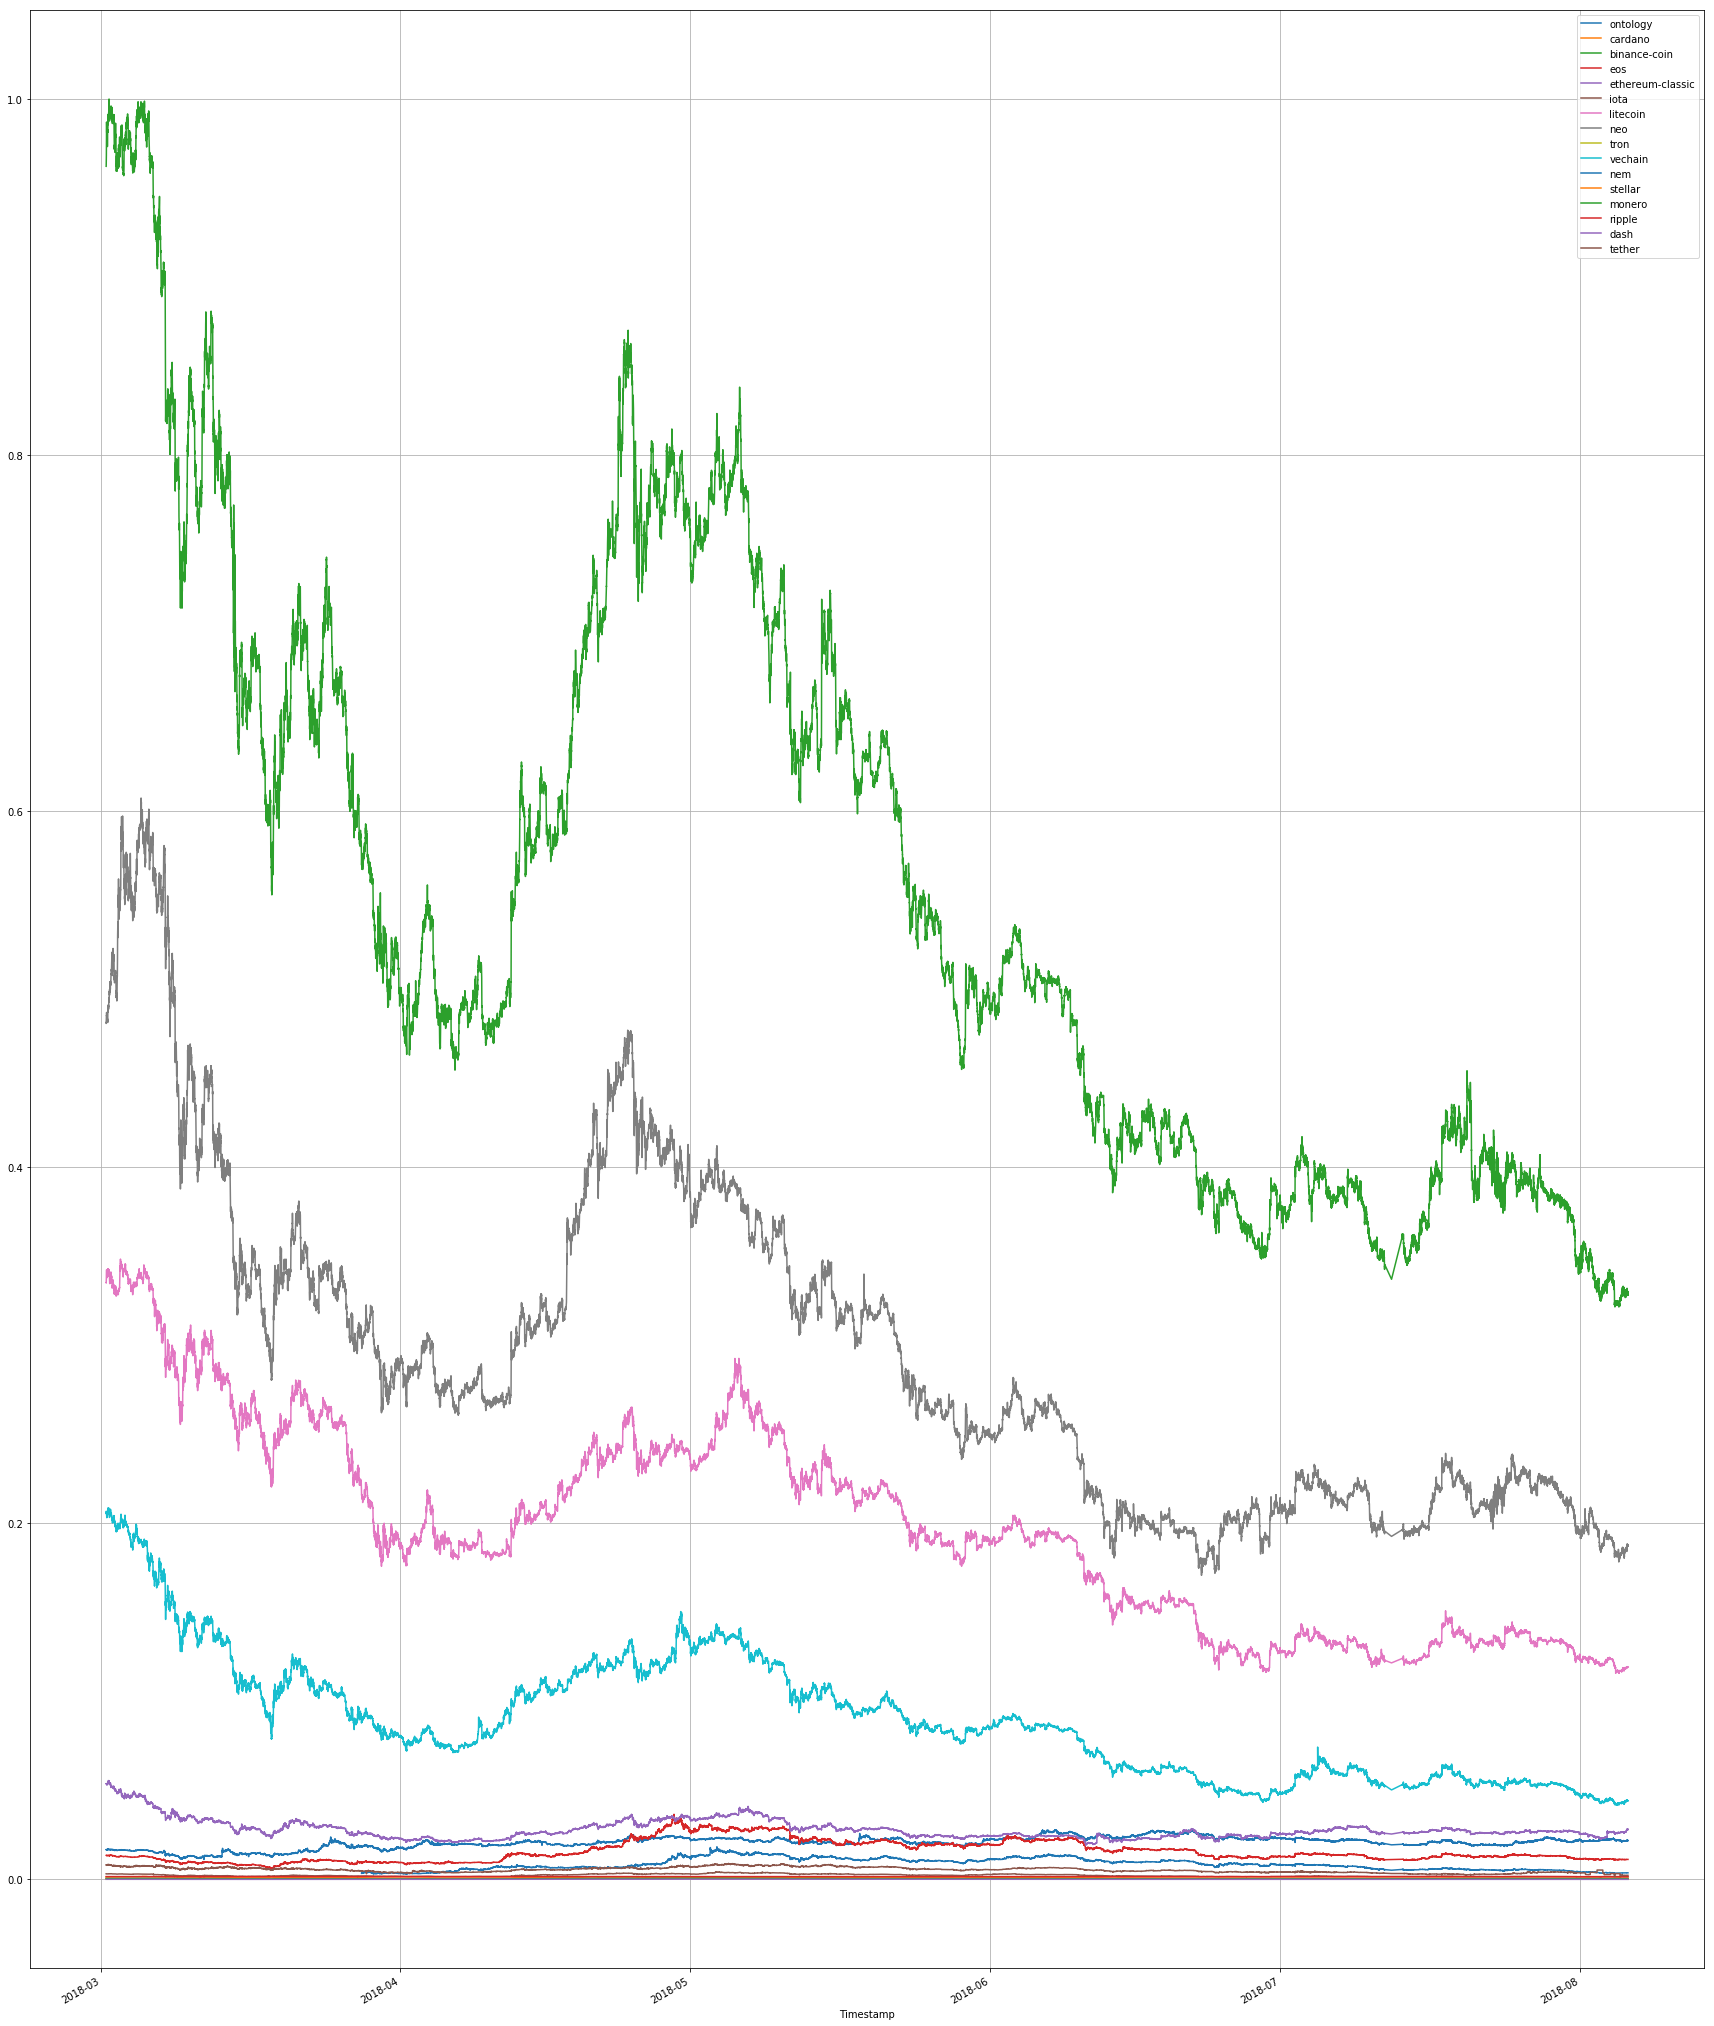

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 40)
names = df.CMC_ID.unique()
df.reset_index().groupby('CMC_ID').plot(x='Timestamp', y='CC_USD_NORM', ax=ax)
plt.legend(names)
plt.grid()
plt.savefig('top20_maraug.png')
plt.show()